In [1]:
import scipy.stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import uniform
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Utility Functions

In [2]:
# Pre-determined parameters
eps = 0.5
u = 1
q = 0.5
alpha_a = 0.2
alpha_b = 0.25
mu_0 = 0
mu_1 = 0.5
mu_2 = 1
sd = 1
mu_c = 0
std_c = 0.25

In [3]:
# Function to get non-strategic optimal threshold
def get_opt_theta_no_strategic(alpha):
    """
    get optimal threshold under non-strategic situation
    """
    val = u*(1-alpha)/(u*alpha)
    from scipy.optimize import fsolve
    func = lambda theta: norm.pdf(theta,mu_2,sd)/norm.pdf(theta,mu_0,sd) - val
    root = fsolve(func,0.2)
    return root[0]

# Function to get non-strategic utility
def get_nonstrat_utility(alpha, theta):
    return u*alpha*(1-norm.cdf(theta,mu_2,sd))-u*(1-alpha)*(1-norm.cdf(theta,mu_0,sd))

In [4]:
# Function to calculate manipulation probability
def get_manip_prob(theta, q, eps):
    """
    function to get manip prob under q and eps
    """
    value = (1-q)*(norm.cdf(theta, mu_1, sd) - norm.cdf(theta, mu_2, sd)) - eps*(1 - norm.cdf(theta, mu_2, sd))
    return norm.cdf(value, mu_c, std_c)

# Function to get Phi under different k1, k2, k3
def get_Phi(alpha, theta, q, eps, k1 = 1, k2 = 1, k3 = 1):
    """
    Get Phi, which is strategic - non-strategic
    k1, k2, k3 measure our preferences for 3 kinds of behaviors
    larger k1 means we prefer improvement
    larger k2 means we do not prefer failure of improvement
    larger k3 means we do not prefer manipulation
    k1=k2=k3=1 is the naive difference
    """
    # manipulation probability
    pm = get_manip_prob(theta, q, eps)
    # Reverse Benefit
    b1 = k1*(1-pm)*q*(2 - norm.cdf(theta, mu_0, sd) - norm.cdf(theta, mu_2, sd))
    # Loss of Failure of Improvement 
    l1 = k2*(1-pm)*(1-q)*(norm.cdf(theta, mu_0, sd) - norm.cdf(theta, mu_1, sd))
    # Loss of manipulation
    l2 = k3*pm*((1-eps)*(1 - norm.cdf(theta,mu_2,sd))-(1-norm.cdf(theta,mu_0,sd)))
    return u*(1-alpha)*(b1-l1-l2)

# Function to get strategic optimal theta under different k1, k2, k3
def get_strat_optimal(alpha, q, eps, k1=1, k2=1, k3=1):
    def get_strat_utility(theta, alpha0 = alpha, k10 = k1, k20 = k2, k30 = k3, q0 = q, eps0 = eps):
        phi = get_Phi(alpha0,theta,q0,eps0,k10,k20,k30)
        U = get_nonstrat_utility(alpha0, theta) + phi
        return -U

    from scipy.optimize import minimize_scalar
    res = minimize_scalar(get_strat_utility)
    return res.x, -get_strat_utility(res.x)

In [5]:
get_strat_optimal(0.3,0.25,0.5)

(0.6507295016177389, 0.045831007982687945)

### Experiments

Under specific combinations of pre-determined parameters, we could first verify whether any case of Theorem 6.1 holds, and then vary $k_1$ or $k_2$ to see the change of optimal threshold, optimal utility, and fairness.

#### Verify process

Firstly we should work out the non-strategic optimal threshold and manipulation probability curve

In [6]:
uhat_a = get_opt_theta_no_strategic(alpha_a)
u_a = get_strat_optimal(alpha_a, q, eps)[0]
nonstrat_a = get_nonstrat_utility(alpha_a, uhat_a)
uhat_b = get_opt_theta_no_strategic(alpha_b)
u_b = get_strat_optimal(alpha_b, q, eps)[0]
nonstrat_b = get_nonstrat_utility(alpha_b, uhat_b)

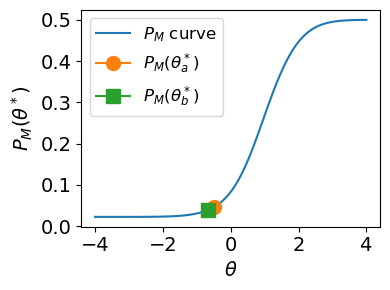

In [12]:
# plot manipulation probability
x = np.linspace(-4,4,100)
plt.figure(figsize = (4,3))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
manip_func = np.vectorize(get_manip_prob, excluded=['q','eps'])
prob = manip_func(x,q,eps)
plt.plot(x,prob,label = r'$P_M$ curve')
prob_a = get_manip_prob(u_a,q,eps)
prob_b = get_manip_prob(u_b,q,eps)
plt.plot(u_a, prob_a,  marker="o", markersize=10, label = r'$P_M(\theta_a^*)$')
plt.plot(u_b, prob_b, marker="s", markersize=10, label = r'$P_M(\theta_b^*)$')
plt.xlabel(r'$\theta$',fontsize = 14)
plt.ylabel(r'$P_M(\theta^*)$',fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig('manipcurve2.pdf')

The figure above demonstrates that condition 1 in 6.1 is satisfied. Thus, we can increase $k_1$ for both groups to disincentivize manipulation, incentivize improvement and promote fairness. The effects are depicted in following plots


In [8]:
# k1_list = np.linspace(1,1000,100)
# k1_list = [1,2,5,10,20,50,100,500,10000]
k1_list = np.linspace(1,2,5)
strat_func = np.vectorize(get_strat_optimal, excluded=['alpha','q','eps, k1, k3'])
theta_a_list = strat_func(alpha_a,q,eps, k1_list, 1,1)[0]
phi_func = np.vectorize(get_Phi, excluded = ['alpha','q','eps','k1','k2','k3'])
nonstrat_func = np.vectorize(get_nonstrat_utility, excluded = ['alpha'])
utility_a_list = phi_func(alpha_a,theta_a_list,q,eps) + nonstrat_func(alpha_a,theta_a_list)
utility_a_non = [get_Phi(alpha_a, uhat_a, q, eps) + get_nonstrat_utility(alpha_a, uhat_a)]*5
manip_list_a = manip_func(theta_a_list,q,eps)
cdf_a = np.array([norm.cdf(theta,mu_2,sd) for theta in theta_a_list])
manip_hat_a = get_manip_prob(uhat_a,q,eps)
cdf_a = np.array([norm.cdf(theta,mu_2,sd) for theta in theta_a_list])
manip_hat_a = get_manip_prob(uhat_a,q,eps)

In [9]:
k1_list = np.linspace(1,2,5)
strat_func = np.vectorize(get_strat_optimal, excluded=['alpha','q','eps, k1, k3'])
theta_b_list = strat_func(alpha_b,q,eps,k1_list, 1,1)[0]
phi_func = np.vectorize(get_Phi, excluded = ['alpha','q','eps','k1','k2','k3'])
nonstrat_func = np.vectorize(get_nonstrat_utility, excluded = ['alpha'])
utility_b_list = phi_func(alpha_b,theta_b_list,q,eps) + nonstrat_func(alpha_b,theta_b_list)
utility_b_non = [get_Phi(alpha_b, uhat_b, q, eps) + get_nonstrat_utility(alpha_b, uhat_b)]*5
manip_list_b = manip_func(theta_b_list,q,eps)
cdf_b = np.array([norm.cdf(theta,mu_2,sd) for theta in theta_b_list])
manip_hat_b = get_manip_prob(uhat_b,q,eps)
cdf_b = np.array([norm.cdf(theta,mu_2,sd) for theta in theta_b_list])
manip_hat_b = get_manip_prob(uhat_b,q,eps)

In [10]:
non_strat_unfairness = norm.cdf(uhat_a,mu_2,sd) - norm.cdf(uhat_b,mu_2,sd)
non_strat_unfairness

0.08698626629890871

In [11]:
utility_b_list

array([0.2505647, 0.2414687, 0.2414687, 0.2414687, 0.2414687])

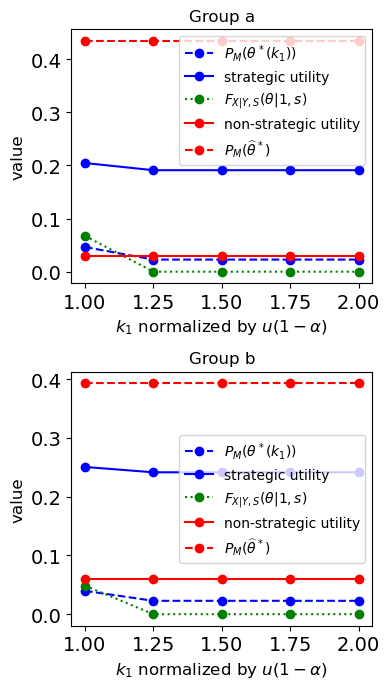

In [13]:
# plot optimal threshold, (non)-strategic utility, and manipulation probability
x = k1_list
fig, axes = plt.subplots(2,1)
fig.set_size_inches(4, 7)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[0].plot(x,manip_list_a, marker = 'o',label = r'$P_M(\theta^*(k_1))$',linestyle = 'dashed',color = 'blue')
axes[0].plot(x,utility_a_list,marker = 'o',label = r'strategic utility',linestyle = 'solid',color = 'blue')
axes[0].plot(x,cdf_a, marker = 'o',label = r'$F_{X|Y,S}(\theta|1,s)$',linestyle = 'dotted',color = 'green')
axes[0].plot(x, utility_a_non, marker = 'o', label = r'non-strategic utility',linestyle = 'solid',color = 'red')
axes[0].plot(x, [manip_hat_a]*5,marker = 'o',label = r'$P_M(\widehat{\theta}^*)$',linestyle = 'dashed',color = 'red')
axes[0].set_xlabel(r'$k_1$ normalized by $u(1-\alpha)$', fontsize = 12)
axes[0].set_ylabel(r'value', fontsize = 12)
axes[0].legend(fontsize = 10)
axes[0].set_title('Group a',fontsize = 12)

axes[1].plot(x,manip_list_b, marker = 'o',label = r'$P_M(\theta^*(k_1))$',linestyle = 'dashed',color = 'blue')
axes[1].plot(x,utility_b_list, marker = 'o',label = r'strategic utility',linestyle = 'solid',color = 'blue')
axes[1].plot(x,cdf_b,marker = 'o',label = r'$F_{X|Y,S}(\theta|1,s)$',linestyle = 'dotted',color = 'green')
axes[1].plot(x, utility_b_non ,marker = 'o', label = r'non-strategic utility',linestyle = 'solid',color = 'red')
axes[1].plot(x, [manip_hat_b]*5, marker = 'o',label = r'$P_M(\widehat{\theta}^*)$',linestyle = 'dashed',color = 'red')
axes[1].set_xlabel(r'$k_1$ normalized by $u(1-\alpha)$', fontsize = 12)
axes[1].set_ylabel(r'value', fontsize = 12)
axes[1].legend(fontsize = 10)
axes[1].set_title('Group b',fontsize = 12)
plt.tight_layout()

fig.savefig('fairness2.pdf')